<a href="https://colab.research.google.com/github/aziegert/Fake_news_detection/blob/main/Fake_news_detection_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
#basic
from google.colab import files
from google.colab import drive
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm
import random
import scipy

#plots
import matplotlib.pyplot as plt

#words
import spacy

#model
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
%matplotlib inline

#Loading data

In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

 93% 38.0M/41.0M [00:00<00:00, 115MB/s]
100% 41.0M/41.0M [00:00<00:00, 111MB/s]


In [ ]:
!unzip /content/fake-and-real-news-dataset.zip

Archive:  /content/fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [ ]:
df_fake = pd.read_csv('/content/Fake.csv')
df_true = pd.read_csv('/content/True.csv')

#EDA

##Date review

In [ ]:
df_fake['is_fake'] = 1
df_fake.head(5)

,title,text,subject,date,is_fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [ ]:
df_true['is_fake'] = 0
df_true.head(5)

,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [ ]:
df = pd.concat([df_fake, df_true]).reset_index(drop=True)
df

,title,text,subject,date,is_fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   is_fake  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [ ]:
#We convert the 'date' column to a date type
df['date_new'] = pd.to_datetime(df['date'], errors='coerce')

# We find all records that are not in the correct format
invalid_dates = df[df['date_new'].isna()]
invalid_dates

,title,text,subject,date,is_fake,date_new
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,1,NaT
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,1,NaT
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,1,NaT
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1,NaT
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1,NaT
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1,NaT
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1,NaT
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,1,NaT
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,1,NaT
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,1,NaT


In [ ]:
df.dropna(subset=['date_new'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     44888 non-null  object        
 1   text      44888 non-null  object        
 2   subject   44888 non-null  object        
 3   date      44888 non-null  object        
 4   is_fake   44888 non-null  int64         
 5   date_new  44888 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 2.4+ MB


In [ ]:
df.drop('date_new', axis=1, inplace=True)

##Text Cleaning and Embeddings

###Cleaning

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
tqdm.pandas()

In [ ]:
def clean_text(text):
  
  clean_text = []
  text = re.sub(r'@\S+', '', text)
  text = nlp(text)
  
  for token in text:
    token.norm_
    token.lemma_
     
    if not (token.is_stop
            or token.is_digit
            or token.is_punct
            or token.like_url
            or token.like_email
            or token.is_space
            or token.is_oov
            or len(token)<2) :

      clean_text.append(token.text)  
     
  return ' '.join(clean_text)

In [ ]:
df['title_progress'] = df['title'].progress_apply(clean_text)
df.sample(5)

100%|██████████| 44888/44888 [08:14<00:00, 90.78it/s] 


,title,text,subject,date,is_fake,title_progress
8792,Kim Davis Utters Four Words To Describe Obama...,Rowan county clerk Kim Davis already had her f...,News,"January 13, 2016",1,Kim Davis Utters Words Describe Obama Speech G...
26226,Stalled Russia sanctions bill hits North Korea...,WASHINGTON (Reuters) - A bill that many lawmak...,politicsNews,"July 14, 2017",0,Stalled Russia sanctions bill hits North Korea...
29390,Homeland Security says will 'comply with judic...,(Reuters) - The U.S. Department of Homeland Se...,politicsNews,"January 29, 2017",0,Homeland Security says comply judicial orders
16882,PATRIOT CALL TO ACTION: A Major Storm Is Brewi...,This is a call to action You guys always talk...,Government News,"Dec 30, 2015",1,PATRIOT ACTION Major Storm Brewing Oregon Fed ...
14795,A MUST READ: Homeland Security Director Reveal...,Have you ever noticed how DHS Director Jeh Joh...,politics,"Dec 14, 2015",1,READ Homeland Security Director Reveals Sides ...


In [ ]:
df['text_progress'] = df['text'].progress_apply(clean_text)
df.sample(5)

100%|██████████| 44888/44888 [1:09:09<00:00, 10.82it/s]


,title,text,subject,date,is_fake,title_progress,title_emb,text_progress
32171,Trump employee apologizes for Melania speech '...,CLEVELAND (Reuters) - A staff writer for the T...,politicsNews,"July 20, 2016",0,Trump employee apologizes Melania speech chaos,"[1.5538384, 0.32557502, -1.6243418, 2.1161666,...",CLEVELAND Reuters staff writer Trump Organizat...
26577,Trump lawyers make final Supreme Court pitch o...,WASHINGTON (Reuters) - The Trump administratio...,politicsNews,"June 21, 2017",0,Trump lawyers final Supreme Court pitch travel...,"[0.48249123, 3.04705, -1.0629625, 2.5656116, 1...",WASHINGTON Reuters Trump administration Wednes...
43718,Hardliners protest French labor reform after M...,PARIS (Reuters) - Tens of thousands of hard-le...,worldnews,"September 11, 2017",0,Hardliners protest French labor reform Macron ...,"[-1.8866061, 0.29881, -1.1778069, 2.2232857, 3...",PARIS Reuters Tens thousands hard left trade u...
34894,"Pakistan allows wife, mother to visit Indian m...",ISLAMABAD (Reuters) - Pakistan allowed the wif...,worldnews,"December 25, 2017",0,Pakistan allows wife mother visit Indian man s...,"[-0.8044689, -0.1768633, -1.7313766, -1.080972...",ISLAMABAD Reuters Pakistan allowed wife mother...
11294,AFGHANISTAN AMBASSADOR Was Delightfully Shocke...,"Donald Trump wanted to win, where as before, ...",politics,"Mar 26, 2017",1,AFGHANISTAN AMBASSADOR Delightfully Shocked Me...,"[0.88387537, 0.020605028, -0.4923081, 0.942696...",Donald Trump wanted win President Obama didn w...


###Embeddings

In [ ]:
df['title_emb'] = df['title_progress'].progress_apply(lambda x: nlp(x).vector)

100%|██████████| 44888/44888 [07:28<00:00, 100.02it/s]


In [ ]:
df['text_emb'] = df['text_progress'].progress_apply(lambda x: nlp(x).vector)

100%|██████████| 44888/44888 [35:32<00:00, 21.05it/s]


##Saving processed data

In [ ]:
drive.mount('/content/drive')

csv_file_path = '/content/drive/MyDrive/Processed_Data/fake_news_processed_data.csv'
df.to_csv(csv_file_path, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Reading processed data

In [ ]:
csv_file_path = '/content/drive/MyDrive/Processed_Data/fake_news_processed_data.csv'
df=pd.read_csv(csv_file_path)

#Splitting our dataset into a train/validation/test split

In [ ]:
class TextDataset(Dataset):
  def __init__(self, vectors, labels):
    self.vectors = vectors
    self.labels = labels
    
  def __len__(self):
    return len(self.labels)
    
  def __getitem__(self, idx):
    return self.vectors[idx], self.labels[idx]

In [ ]:
def get_dataloaders(X, y, batch_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=6)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=6)   

  X_train, X_val, X_test = torch.Tensor(X_train.tolist()), torch.Tensor(X_val.tolist()), torch.Tensor(X_test.tolist())
  y_train, y_val, y_test = torch.Tensor(y_train.values), torch.Tensor(y_val.values), torch.Tensor(y_test.values)

  train_data = TextDataset(X_train, y_train)
  val_data = TextDataset(X_val, y_val)
  test_data = TextDataset(X_test, y_test)

  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

  return  train_dataloader, val_dataloader, test_dataloader

#Neural Network

##Model bulding

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs, dropout):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(n_inputs, n_hidden)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(n_hidden, n_outputs)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)

In [ ]:
n_inputs = 300
n_hidden = 50
n_outputs = 1
dropout = 0.1

learning_rate = 0.001

In [ ]:
model = SimpleNet(n_inputs, n_hidden, n_outputs, dropout)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()

In [ ]:
def train_loop(dataloader, model, optimizer, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct, correct_sum = 0, 0, 0

    for batch, (vectors, labels) in enumerate(dataloader):
        
      # Compute prediction and loss
      outputs = model(vectors)
      loss = criterion(outputs, labels.unsqueeze(1))

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss +=loss.item()
      predicted = torch.round(outputs)
      correct = torch.eq(predicted, labels.unsqueeze(1)).sum()
      correct_sum += correct.item()

    train_loss /= num_batches
    accuracy = 100 * correct_sum / size
    print(f'Loss: {train_loss:.6f},  Accuracy: {accuracy:.2f}%', end='    ')

    return train_loss, accuracy


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct, correct_sum = 0, 0, 0

    with torch.no_grad():
        for vectors, labels in dataloader:
            outputs = model(vectors)
            test_loss += criterion(outputs, labels.unsqueeze(1)).item()
            predicted = torch.round(outputs)
            correct = torch.eq(predicted, labels.unsqueeze(1)).sum()
            correct_sum += correct.item()

    test_loss /= num_batches
    accuracy = 100 * correct_sum / size
    print(f'Loss: {test_loss:.6f},  Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

##Prediction based on 'title'

In [ ]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(df['title_emb'], df['is_fake'], batch_size=512)

In [ ]:
epochs = 100
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
best_accuracy = 0

model.apply(weights_init)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}:  ', end='')
    print(f'Train: ', end='')
    train_loss, train_accuracy = train_loop(train_dataloader, model, optimizer, criterion)
    print(f'Validation: ', end='')
    val_loss, val_accuracy = test_loop(val_dataloader, model, criterion)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
        torch.save(model.state_dict(), 'best_model.pt')

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

print('Done!')

Epoch 1:  Train: Loss: 0.151185,  Accuracy: 94.40%    Validation: Loss: 0.039277,  Accuracy: 98.76%
Epoch 2:  Train: Loss: 0.034158,  Accuracy: 98.88%    Validation: Loss: 0.028924,  Accuracy: 99.05%
Epoch 3:  Train: Loss: 0.026794,  Accuracy: 99.13%    Validation: Loss: 0.024287,  Accuracy: 99.15%
Epoch 4:  Train: Loss: 0.024516,  Accuracy: 99.18%    Validation: Loss: 0.021711,  Accuracy: 99.33%
Epoch 5:  Train: Loss: 0.021230,  Accuracy: 99.27%    Validation: Loss: 0.020109,  Accuracy: 99.28%
Epoch 6:  Train: Loss: 0.018726,  Accuracy: 99.40%    Validation: Loss: 0.017610,  Accuracy: 99.41%
Epoch 7:  Train: Loss: 0.017291,  Accuracy: 99.41%    Validation: Loss: 0.018353,  Accuracy: 99.40%
Epoch 8:  Train: Loss: 0.015575,  Accuracy: 99.50%    Validation: Loss: 0.015727,  Accuracy: 99.47%
Epoch 9:  Train: Loss: 0.014045,  Accuracy: 99.53%    Validation: Loss: 0.015308,  Accuracy: 99.44%
Epoch 10:  Train: Loss: 0.013439,  Accuracy: 99.56%    Validation: Loss: 0.016090,  Accuracy: 99.39%

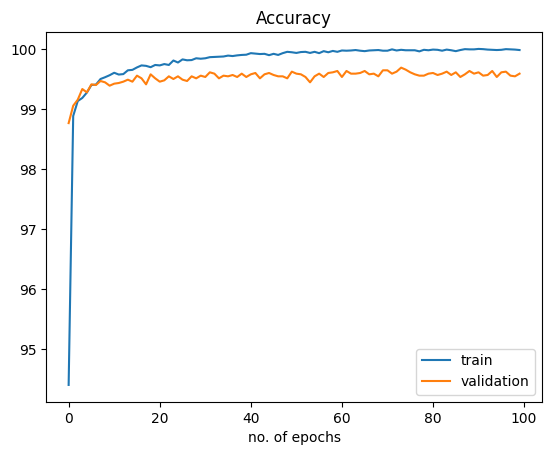

In [ ]:
#Plot of Accuracy
plt.plot(train_accuracy_history, label='train')
plt.plot(val_accuracy_history, label='validation')
plt.xlabel("no. of epochs")
plt.title("Accuracy")
plt.legend()
plt.show()

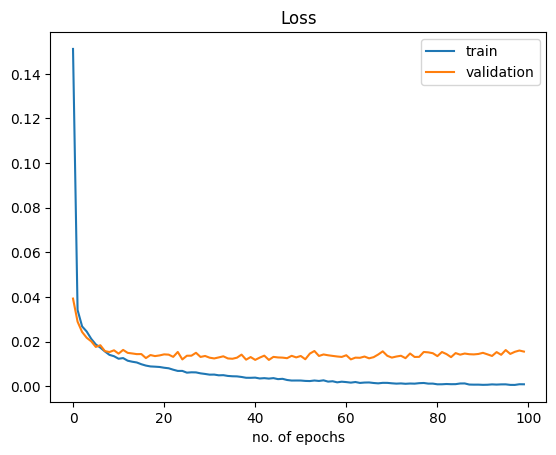

In [ ]:
#Plot of Loss
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='validation')
plt.xlabel('no. of epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
best_title_model = best_model
test_loss, test_accuracy = test_loop(test_dataloader, best_title_model, criterion)

Loss: 0.033077,  Accuracy: 99.69%


##Prediction based on 'text'

In [ ]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(df['text_emb'], df['is_fake'], batch_size=128)

In [ ]:
epochs = 100
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
best_accuracy = 0

for epoch in range(epochs):
    print(f'Epoch {epoch+1}:  ', end='')
    print(f'Train: ', end='')
    train_loss, train_accuracy = train_loop(train_dataloader, model, optimizer, criterion)
    print(f'Validation: ', end='')
    val_loss, val_accuracy = test_loop(val_dataloader, model, criterion)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
        torch.save(model.state_dict(), 'best_model.pt')

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

print('Done!')

Epoch 1:  Train: Loss: 0.289653,  Accuracy: 90.28%    Validation: Loss: 0.163750,  Accuracy: 93.73%
Epoch 2:  Train: Loss: 0.156597,  Accuracy: 94.23%    Validation: Loss: 0.141759,  Accuracy: 94.78%
Epoch 3:  Train: Loss: 0.137162,  Accuracy: 94.88%    Validation: Loss: 0.127098,  Accuracy: 95.31%
Epoch 4:  Train: Loss: 0.125424,  Accuracy: 95.37%    Validation: Loss: 0.128147,  Accuracy: 95.37%
Epoch 5:  Train: Loss: 0.117362,  Accuracy: 95.69%    Validation: Loss: 0.116365,  Accuracy: 95.69%
Epoch 6:  Train: Loss: 0.111204,  Accuracy: 95.92%    Validation: Loss: 0.111651,  Accuracy: 95.82%
Epoch 7:  Train: Loss: 0.106572,  Accuracy: 96.09%    Validation: Loss: 0.105562,  Accuracy: 96.22%
Epoch 8:  Train: Loss: 0.100653,  Accuracy: 96.37%    Validation: Loss: 0.112301,  Accuracy: 96.15%
Epoch 9:  Train: Loss: 0.099029,  Accuracy: 96.27%    Validation: Loss: 0.097326,  Accuracy: 96.56%
Epoch 10:  Train: Loss: 0.096968,  Accuracy: 96.46%    Validation: Loss: 0.102000,  Accuracy: 96.40%

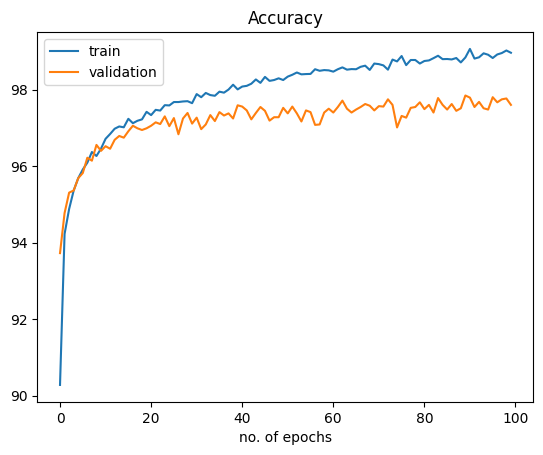

In [ ]:
#Plot of Accuracy
plt.plot(train_accuracy_history, label='train')
plt.plot(val_accuracy_history, label='validation')
plt.xlabel("no. of epochs")
plt.title("Accuracy")
plt.legend()
plt.show()

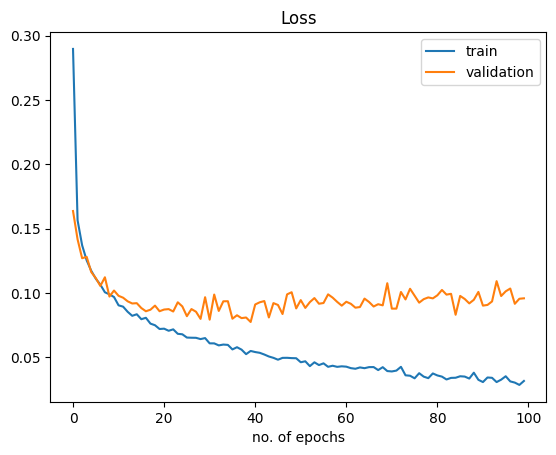

In [ ]:
#Plot of Loss
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='validation')
plt.xlabel('no. of epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
best_text_model = best_model
test_loss, test_accuracy = test_loop(test_dataloader, best_text_model, criterion)

Loss: 0.091146,  Accuracy: 97.44%


#Comparisons

##Without cutting "stopwords"

In [ ]:
def clean_text_with_stopwords(text):
  
  clean_text = []
  text = re.sub(r'@\S+', '', text)
  text = nlp(text)
  
  for token in text:
    token.norm_
    token.lemma_
     
    if not (token.is_digit
            or token.is_punct
            or token.like_url
            or token.like_email
            or token.is_space
            or token.is_oov
            or len(token)<2) :

      clean_text.append(token.text)  
     
  return ' '.join(clean_text)

In [ ]:
df['title_progress_with_stopwords'] = df['title'].progress_apply(clean_text_with_stopwords)

100%|██████████| 44888/44888 [08:15<00:00, 90.61it/s] 


In [ ]:
df['title_emb_with_stopwords'] = df['title_progress_with_stopwords'].progress_apply(lambda x: nlp(x).vector)

100%|██████████| 44888/44888 [09:06<00:00, 82.18it/s]


In [ ]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(df['title_emb_with_stopwords'], df['is_fake'], batch_size=512)

In [ ]:
epochs = 100
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
best_accuracy = 0

model.apply(weights_init)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}:  ', end='')
    print(f'Train: ', end='')
    train_loss, train_accuracy = train_loop(train_dataloader, model, optimizer, criterion)
    print(f'Validation: ', end='')
    val_loss, val_accuracy = test_loop(val_dataloader, model, criterion)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
        torch.save(model.state_dict(), 'best_model.pt')

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

print('Done!')

Epoch 1:  Train: Loss: 0.160640,  Accuracy: 95.38%    Validation: Loss: 0.036250,  Accuracy: 98.74%
Epoch 2:  Train: Loss: 0.031347,  Accuracy: 99.07%    Validation: Loss: 0.025064,  Accuracy: 99.25%
Epoch 3:  Train: Loss: 0.024160,  Accuracy: 99.29%    Validation: Loss: 0.022577,  Accuracy: 99.34%
Epoch 4:  Train: Loss: 0.021413,  Accuracy: 99.36%    Validation: Loss: 0.020405,  Accuracy: 99.39%
Epoch 5:  Train: Loss: 0.019051,  Accuracy: 99.49%    Validation: Loss: 0.017643,  Accuracy: 99.44%
Epoch 6:  Train: Loss: 0.017689,  Accuracy: 99.53%    Validation: Loss: 0.016327,  Accuracy: 99.51%
Epoch 7:  Train: Loss: 0.015672,  Accuracy: 99.61%    Validation: Loss: 0.016629,  Accuracy: 99.50%
Epoch 8:  Train: Loss: 0.014478,  Accuracy: 99.66%    Validation: Loss: 0.015885,  Accuracy: 99.52%
Epoch 9:  Train: Loss: 0.014000,  Accuracy: 99.66%    Validation: Loss: 0.015605,  Accuracy: 99.58%
Epoch 10:  Train: Loss: 0.013374,  Accuracy: 99.72%    Validation: Loss: 0.015488,  Accuracy: 99.49%

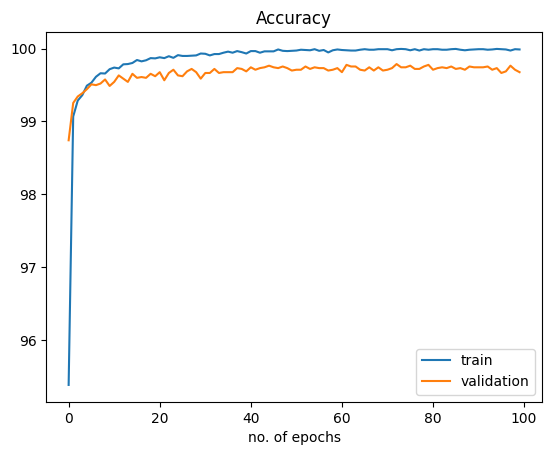

In [ ]:
#Plot of Accuracy
plt.plot(train_accuracy_history, label='train')
plt.plot(val_accuracy_history, label='validation')
plt.xlabel("no. of epochs")
plt.title("Accuracy")
plt.legend()
plt.show()

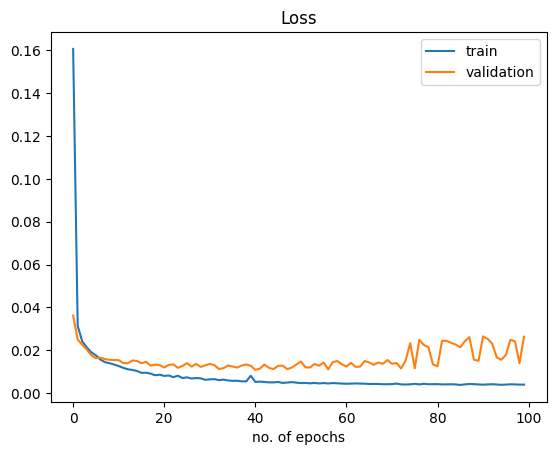

In [ ]:
#Plot of Loss
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='validation')
plt.xlabel('no. of epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
best_title_model_with_stopwords = best_model
test_loss, test_accuracy = test_loop(test_dataloader, best_title_model_with_stopwords, criterion)

Loss: 0.022601,  Accuracy: 99.79%


##Without lemmatization

In [ ]:
def clean_text_without_lemma(text):
  
  clean_text = []
  text = re.sub(r'@\S+', '', text)
  text = nlp(text)
  
  for token in text:
    token.norm_
     
    if not (token.is_stop
            or token.is_digit
            or token.is_punct
            or token.like_url
            or token.like_email
            or token.is_space
            or token.is_oov
            or len(token)<2) :

      clean_text.append(token.text)  
     
  return ' '.join(clean_text)

In [ ]:
df['title_progress_withot_lemma'] = df['title'].progress_apply(clean_text_without_lemma)

100%|██████████| 44888/44888 [08:13<00:00, 90.92it/s] 


In [ ]:
df['title_emb_withot_lemma'] = df['title_progress_withot_lemma'].progress_apply(lambda x: nlp(x).vector)

100%|██████████| 44888/44888 [08:04<00:00, 92.63it/s] 


In [ ]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(df['title_emb_withot_lemma'], df['is_fake'], batch_size=512)

In [ ]:
epochs = 100
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
best_accuracy = 0

model.apply(weights_init)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}:  ', end='')
    print(f'Train: ', end='')
    train_loss, train_accuracy = train_loop(train_dataloader, model, optimizer, criterion)
    print(f'Validation: ', end='')
    val_loss, val_accuracy = test_loop(val_dataloader, model, criterion)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
        torch.save(model.state_dict(), 'best_model.pt')

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

print('Done!')

Epoch 1:  Train: Loss: 0.086790,  Accuracy: 96.67%    Validation: Loss: 0.035812,  Accuracy: 98.72%
Epoch 2:  Train: Loss: 0.029250,  Accuracy: 99.02%    Validation: Loss: 0.025781,  Accuracy: 99.18%
Epoch 3:  Train: Loss: 0.022888,  Accuracy: 99.25%    Validation: Loss: 0.021619,  Accuracy: 99.32%
Epoch 4:  Train: Loss: 0.019715,  Accuracy: 99.38%    Validation: Loss: 0.020012,  Accuracy: 99.33%
Epoch 5:  Train: Loss: 0.016375,  Accuracy: 99.47%    Validation: Loss: 0.017623,  Accuracy: 99.35%
Epoch 6:  Train: Loss: 0.014926,  Accuracy: 99.57%    Validation: Loss: 0.018070,  Accuracy: 99.40%
Epoch 7:  Train: Loss: 0.013815,  Accuracy: 99.54%    Validation: Loss: 0.015812,  Accuracy: 99.45%
Epoch 8:  Train: Loss: 0.012204,  Accuracy: 99.60%    Validation: Loss: 0.015506,  Accuracy: 99.41%
Epoch 9:  Train: Loss: 0.011678,  Accuracy: 99.61%    Validation: Loss: 0.015952,  Accuracy: 99.40%
Epoch 10:  Train: Loss: 0.010273,  Accuracy: 99.70%    Validation: Loss: 0.015589,  Accuracy: 99.48%

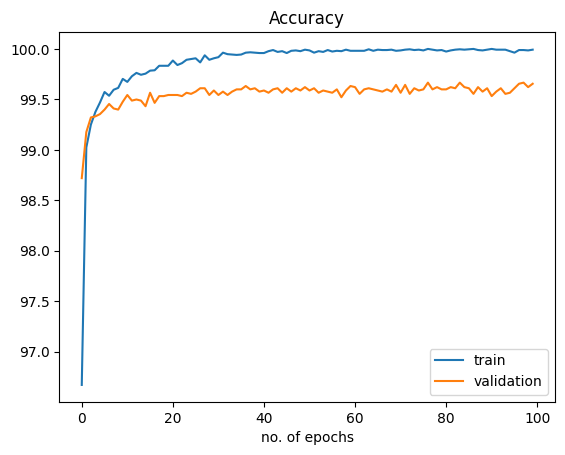

In [ ]:
#Plot of Accuracy
plt.plot(train_accuracy_history, label='train')
plt.plot(val_accuracy_history, label='validation')
plt.xlabel("no. of epochs")
plt.title("Accuracy")
plt.legend()
plt.show()

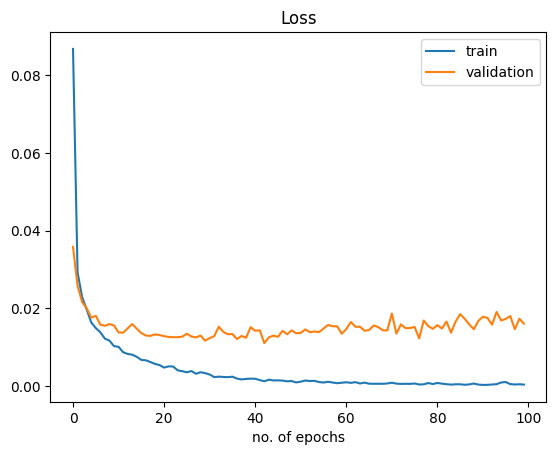

In [ ]:
#Plot of Loss
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='validation')
plt.xlabel('no. of epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
best_title_model_withot_lemma = best_model
test_loss, test_accuracy = test_loop(test_dataloader, best_title_model_withot_lemma, criterion)

Loss: 0.033715,  Accuracy: 99.68%


##Summary

In [ ]:
df_subject = pd.DataFrame({'Model': ['Without_Model_Based_on_Subject'], 'Loss': [0.000000], 'Accuracy': ['100%']})
df_reg_log_spacy = pd.DataFrame({'Model': ['LogisticRegression_with_Spacy'], 'Loss': [0.015593], 'Accuracy': ['99.52%']})
df_reg_log_transf = pd.DataFrame({'Model': ['LogisticRegression_with_Transformer'], 'Loss': [0.097265], 'Accuracy': ['96.16%']})
df_simple_net = pd.DataFrame({'Model': ['SimpleNet'], 'Loss': [0.033077], 'Accuracy': ['99.69%']})
df_simple_net_stopwords = pd.DataFrame({'Model': ['SimpleNet_with_Stopwords'], 'Loss': [0.022601], 'Accuracy': ['99.79%']})
df_simple_net_lemma = pd.DataFrame({'Model': ['SimpleNet_without_Lemmatization'], 'Loss': [0.033715], 'Accuracy': ['99.68%']})

In [ ]:
comparison = pd.concat([df_subject, df_reg_log_spacy, df_reg_log_transf, df_simple_net, df_simple_net_stopwords, df_simple_net_lemma])
comparison = comparison.reset_index(drop=True)
comparison

,Model,Loss,Accuracy
0,Without_Model_Based_on_Subject,0.000000,100%
1,LogisticRegression_with_Spacy,0.015593,99.52%
2,LogisticRegression_with_Transformer,0.097265,96.16%
3,SimpleNet,0.033077,99.69%
4,SimpleNet_with_Stopwords,0.022601,99.79%
5,SimpleNet_without_Lemmatization,0.033715,99.68%


#Finding similar news

##For title

In [ ]:
corpus_title_embeddings = []

for vectors in df['title_emb']:
  corpus_title_embeddings.append(vectors)

In [ ]:
id_title = random.randint(0, len(df))
news_title = df['title'][id_title]
news_title_emb = df['title_emb'][id_title]
news_title

'Casualties in explosion at airfield near Kabul: U.S. military'

In [ ]:
closet_n = 5

distances = scipy.spatial.distance.cdist([news_title_emb], corpus_title_embeddings, 'cosine')[0]

results = zip(range(len(distances)), distances)
results = sorted(results, key=lambda x: x[1])
results = pd.DataFrame(results)

print('News title:\n', news_title)
print('\nTop 5 most similiar news title in all titles:\n')

for i in range(closet_n):
  id = results[0][i]
  news = df['title'].iloc[id]
  print(f'{news} \n Score: {round(results[1][i], 4)}  ID: {id}\n')

News title:
 Casualties in explosion at airfield near Kabul: U.S. military

Top 5 most similiar news title in all titles:

Casualties in explosion at airfield near Kabul: U.S. military 
 Score: 0.0  ID: 44315

U.S. military aircraft crashes in Syria, injuring two: officials 
 Score: 0.1168  ID: 42175

U.S.-led surveillance aircraft leave area near Islamic State convoy in Syria 
 Score: 0.1308  ID: 44070

Turkish military kills three PKK militants in north Iraq near border: sources 
 Score: 0.1428  ID: 42203

Violence flares at protest near U.S. Embassy in Lebanon 
 Score: 0.1511  ID: 36106



##For text

In [ ]:
corpus_text_embeddings = []

for vectors in df['text_emb']:
  corpus_text_embeddings.append(vectors)

In [ ]:
id_news = random.randint(0, len(df))
news = df['text'][id_news]
news_emb = df['text_emb'][id_news]
news

'WASHINGTON (Reuters) - Republican presidential candidate Donald Trump’s team of economic policy advisers is packed with moguls from the hedge fund and investment banking industries that he has railed against in the past. And none of them are women - a demographic group he needs to court if he hopes to win in November. Trump’s campaign has been powered by a populist message that criticizes corporate America for outsourcing jobs, profiting at the expense of everyday workers and buying influence in Washington. The message resonates best with middle-class and working-class voters buffeted by the forces of globalization.  But among the members of the 13-member team of advisers announced on Friday are hedge-fund billionaire John Paulson and investment bankers Steve Feinberg and Andy Beal, as well as a former top steel executive and a former high-ranking U.S. government official.  “\u200eIt is a hallowed campaign tradition. Malign an industry, but court its wealthy big shots,” said\xa0Erik G

In [ ]:
closet_n = 5

distances = scipy.spatial.distance.cdist([news_emb], corpus_text_embeddings, 'cosine')[0]

results_text = zip(range(len(distances)), distances)
results_text = sorted(results_text, key=lambda x: x[1])
results_text = pd.DataFrame(results_text)

print('News:\n', news)
print('\nTop 5 most similiar news:\n')

for i in range(closet_n):
  id = results_text[0][i]
  news = df['text'].iloc[id]
  print(f'{news} \n Score: {round(results_text[1][i], 4)}  ID: {id}\n')

News:
 WASHINGTON (Reuters) - Republican presidential candidate Donald Trump’s team of economic policy advisers is packed with moguls from the hedge fund and investment banking industries that he has railed against in the past. And none of them are women - a demographic group he needs to court if he hopes to win in November. Trump’s campaign has been powered by a populist message that criticizes corporate America for outsourcing jobs, profiting at the expense of everyday workers and buying influence in Washington. The message resonates best with middle-class and working-class voters buffeted by the forces of globalization.  But among the members of the 13-member team of advisers announced on Friday are hedge-fund billionaire John Paulson and investment bankers Steve Feinberg and Andy Beal, as well as a former top steel executive and a former high-ranking U.S. government official.  “‎It is a hallowed campaign tradition. Malign an industry, but court its wealthy big shots,” said Erik Gor